In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import datetime
import seaborn as sns
from datetime import date
from sklearn.preprocessing import LabelEncoder

## Trend evaluation with annotated dataset
### Goal: generate rehabilitation pattern with minimum notes needed to have a reliable estimate

#### Levels
FAC and INS have a scale between 0-5, where 5 means there is no functioning problem.
The rest of the domains have a scale between 0-4, where 4 means there is no functioning problem.


In [24]:
df = pd.read_table("./processed/covid_data_with_levels_anonimized.csv", sep=',' , index_col=0)

In [3]:
#by doing this aprox 40k instances are deleted, meaning they don't have any domain assigned.
#with this there is no need to repeat dropna later 
df = df.dropna(axis = 0, how='all', subset=['ADM_lvl','ATT_lvl','BER_lvl','ENR_lvl','ETN_lvl', 'FAC_lvl','INS_lvl','MBW_lvl','STM_lvl']) #rows with all values Nan ##can also try this thresh=2

In [4]:
#selection of id's with more than 100 notes. checking if still 1290 ids
unique_id = df['MDN'].unique()
df['MDN'].nunique() #1290 unique ids
df.head()
df = df.sort_values(by=["MDN", "Notitiedatum"])

In [5]:
#filter ids with a minimum of 100 notes. Now 192 unique IDs with over 100 notes
df_fil100 = df.groupby(['MDN']).filter(lambda x: len(x) > 100)
df_fil100.nunique()

#also filter by minimum 100 different dates per id. 190 unique IDs
df_fildate =  df_fil100.groupby('Notitiedatum').filter(lambda x : len(x)>100) 
df_fildate['MDN'].nunique()

190

## Example of tracking an unique ID 

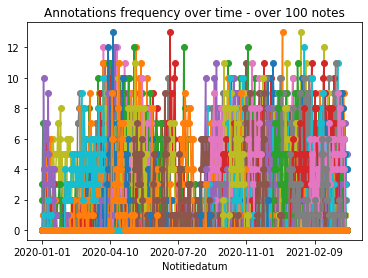

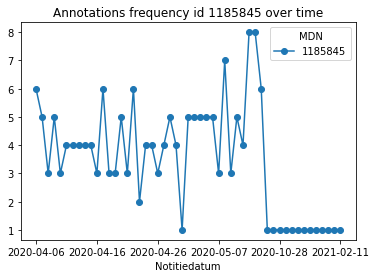

In [6]:
#example of tracking frequency of all ids an unique ID
pd.crosstab(df_fil100['Notitiedatum'], df_fil100['MDN']).plot(title= 'Annotations frequency over time - over 100 notes', marker='o', legend= False)

#randomly select an ID and plot annotation frequency, independent of domain
df_1185845 = df_fildate[df_fildate['MDN'] == 1185845]
pd.crosstab(df_1185845['Notitiedatum'], df_1185845['MDN']).plot(title= 'Annotations frequency id 1185845 over time', marker='o')


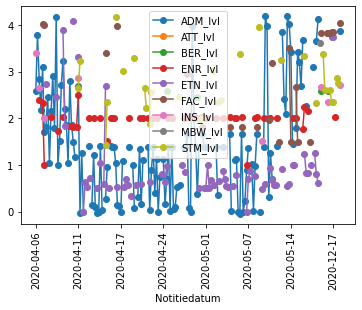

In [7]:
df_1185845.plot(y=['ADM_lvl','ATT_lvl','BER_lvl','ENR_lvl','ETN_lvl', 'FAC_lvl','INS_lvl','MBW_lvl','STM_lvl'],x='Notitiedatum',marker='o', rot=90)

## Reproducing findings in a generalized way

In [8]:
#investigate out of the 190 IDs the ones with higher count number in any of the domains
cross_id_dom = df_fildate.groupby(by='MDN', as_index=False).count()

cross_id_dom50 = cross_id_dom[cross_id_dom['ADM_lvl'] > 50]
cross_id_dom50 = cross_id_dom[(cross_id_dom['ADM_lvl']> 50) | (cross_id_dom['ATT_lvl']> 50) | (cross_id_dom['BER_lvl']> 50) 
| (cross_id_dom['ENR_lvl']> 50) | (cross_id_dom['ETN_lvl']> 50)| (cross_id_dom['FAC_lvl']> 50)
| (cross_id_dom['INS_lvl']> 50)| (cross_id_dom['MBW_lvl']> 50) | (cross_id_dom['STM_lvl']> 50)]

#for 100 points per domain per person we have only 57 IDs. 
# for 50 points per domain per person we have 149 IDs int the end. df that reflects this is df_final
cross_id_dom50

MDN  institution  NotitieID  Typenotitie  Notitiedatum  annotated  \
0     138098          161        161          160           161        161   
1     406479          105        105          103           105        105   
2     544716          109        109          107           109        109   
3     762325           66         66           66            66         66   
5     840595           91         91           91            91         91   
..       ...          ...        ...          ...           ...        ...   
179  9256011           73         73           71            73         73   
180  9284804           67         67           66            67         67   
181  9470821          146        146          143           146        146   
188  9817236          155        155          154           155        155   
189  9964647           97         97           95            97         97   

     ADM_lvl  ATT_lvl  BER_lvl  ENR_lvl  ETN_lvl  FAC_lvl  INS_lvl  MBW_lvl  \
0        135        1        4       23       40       24       16       18   
1         89        2        0        3       43       24       20        2   
2         82        1        0       10       36       41        5        8   
3         56        0        2        9       29        7        8        4   
5         80        0        0       17       27       40        8        8   
..       ...      ...      ...      ...      ...      ...      ...      ...   
179       60        0        0        5       21       16        6       10   
180       52        0        0        8       35        7       11        4   
181       99        0        0       10       74       28       28        4   
188      106        0        0       17       70       17       43       10   
189       78        0        2       17       42       18        4        2   

     STM_lvl  
0         36  
1         15  
2         24  
3          3  
5         18  
..       ...  
179        6  
180        2  
181       23  
188       28  
189       17  

[149 rows x 15 columns]

AxesSubplot(0.125,0.125;0.775x0.755)


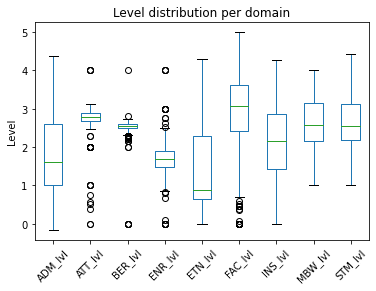

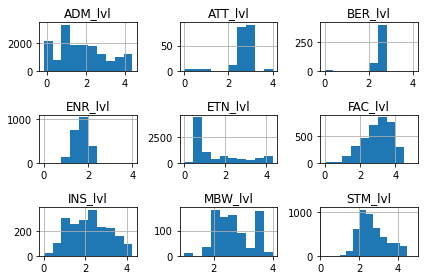

In [9]:
#cross_id_dom50['MDN'].unique()
columns = ['ADM_lvl','ATT_lvl','BER_lvl','ENR_lvl','ETN_lvl', 'FAC_lvl','INS_lvl','MBW_lvl','STM_lvl']
ids = cross_id_dom50['MDN'].unique()

#distribution of levels per domain for the filtered dataset
lev_dom_boxplot = df_fildate.boxplot(column = columns, grid=False, rot=45, fontsize=10)
plt.gca().set(title='Level distribution per domain', ylabel='Level')
print(lev_dom_boxplot)
plt.savefig('./figures/level_domain_boxplot.png')

hist = df_fildate[columns].hist() #fac and ins have 5 levels, all other domains have 4
plt.xlim(0,5)
plt.tight_layout()
plt.savefig('./figures/level_domain_histogram.png')


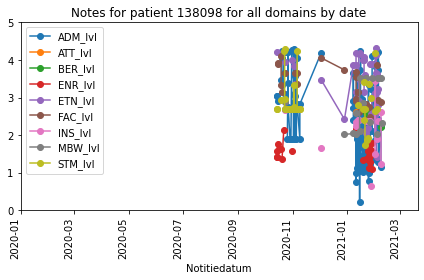

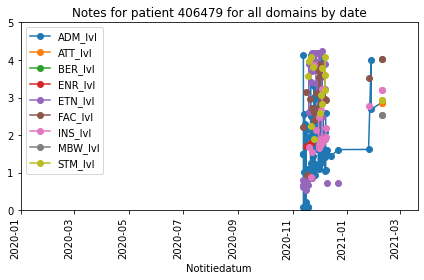

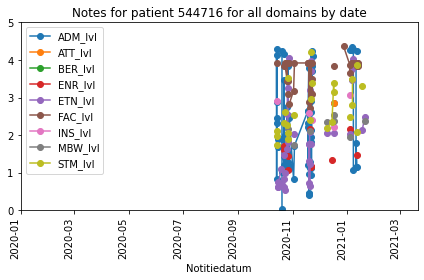

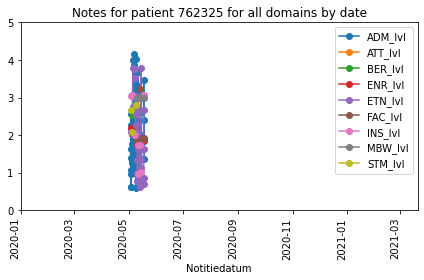

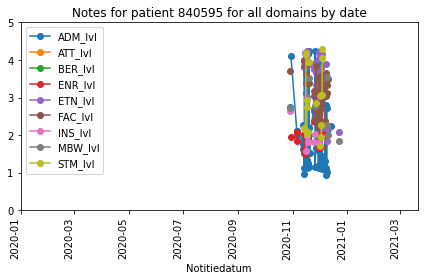

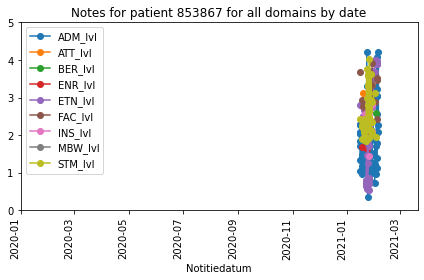

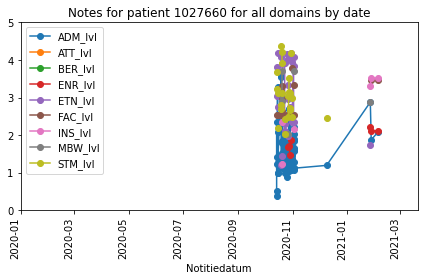

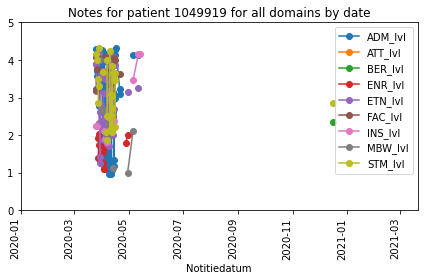

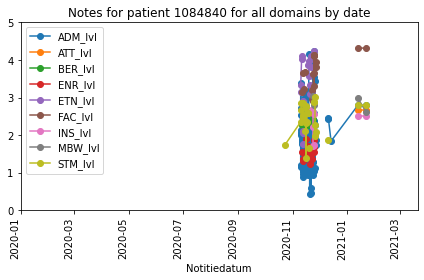

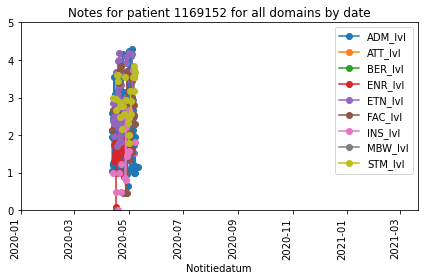

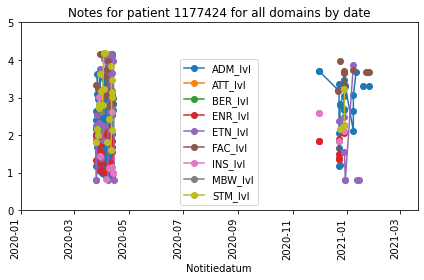

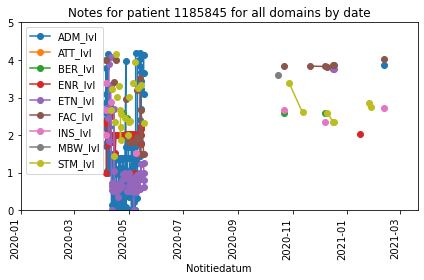

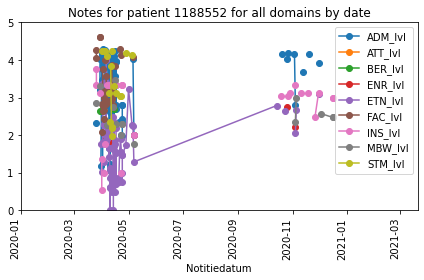

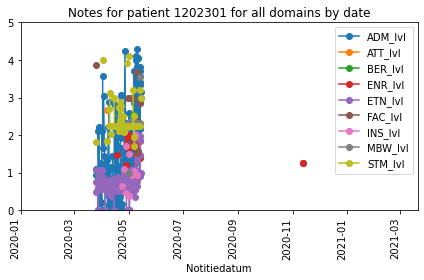

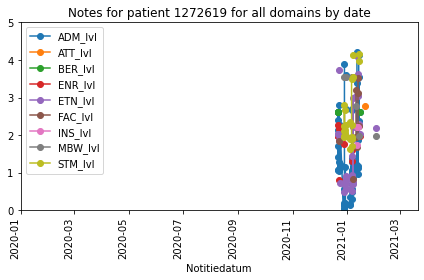

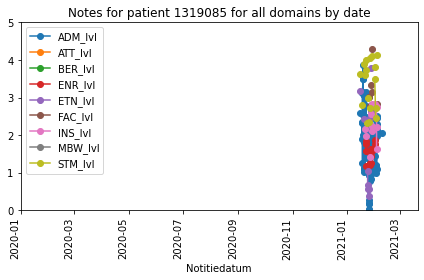

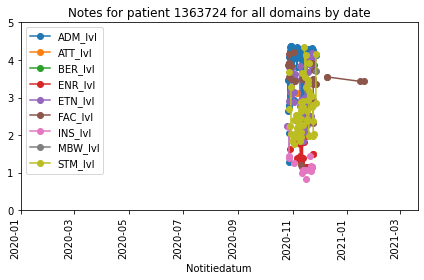

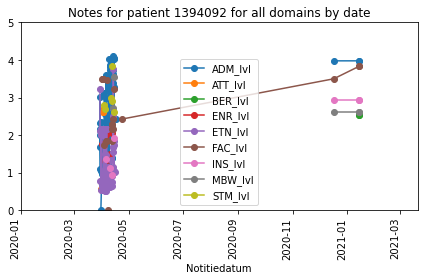

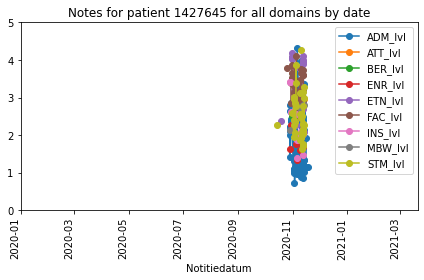

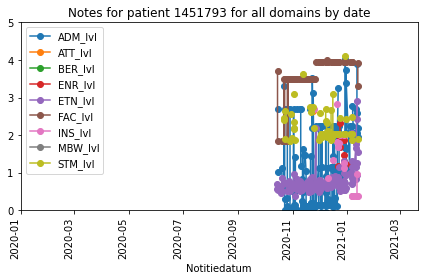

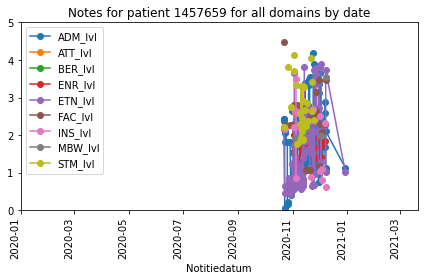

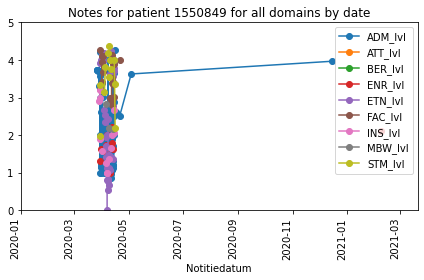

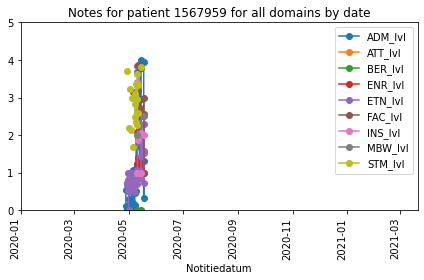

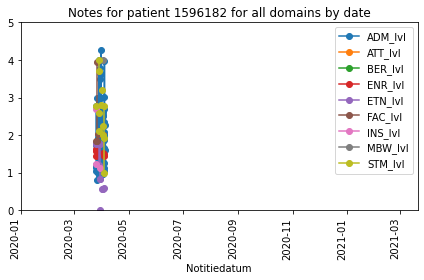

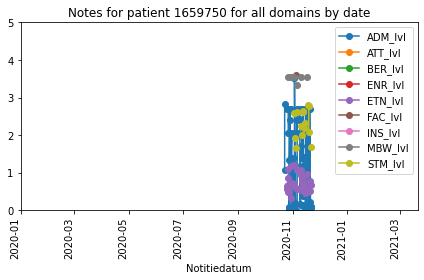

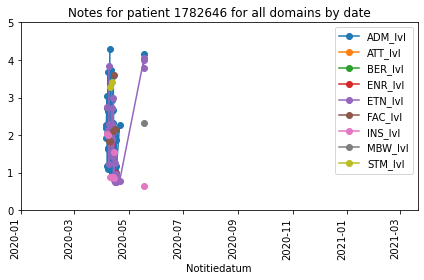

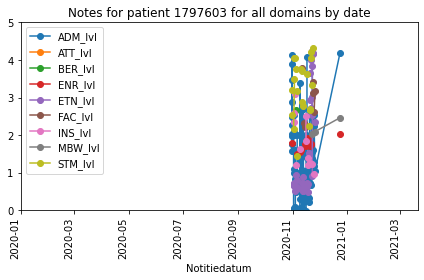

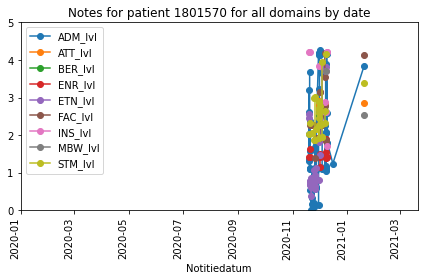

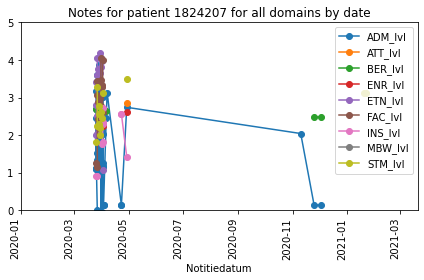

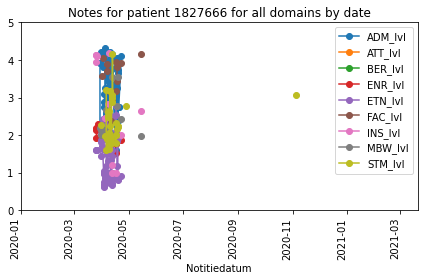

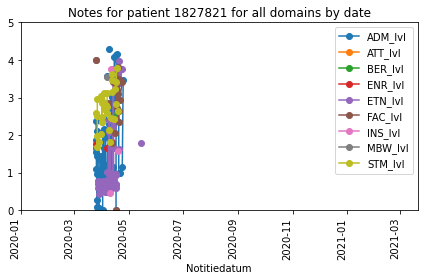

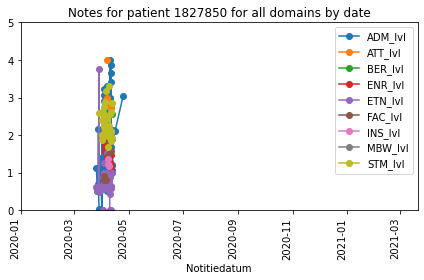

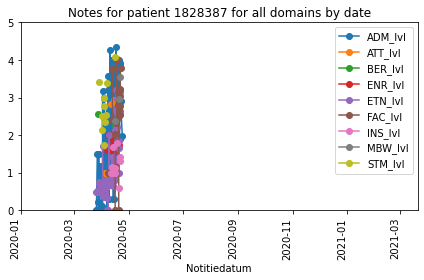

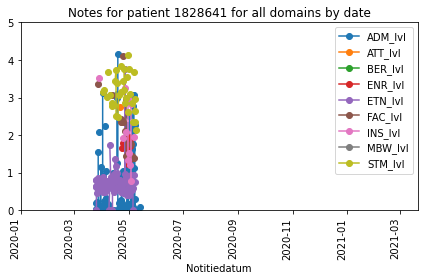

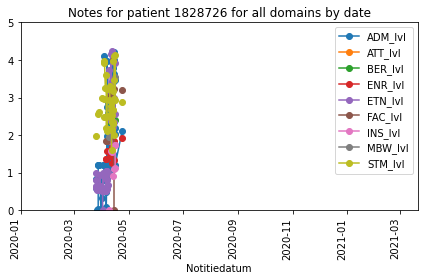

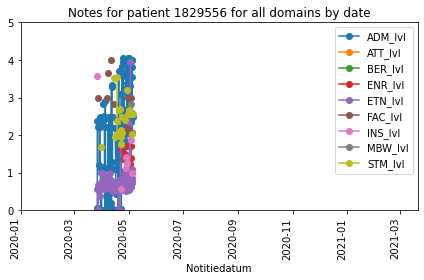

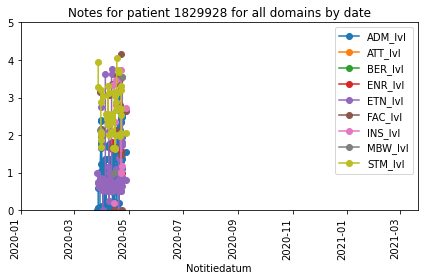

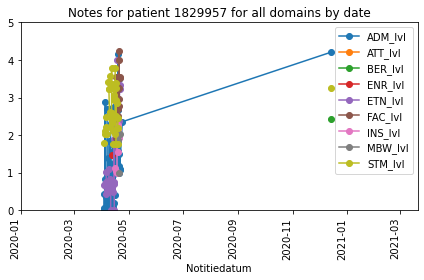

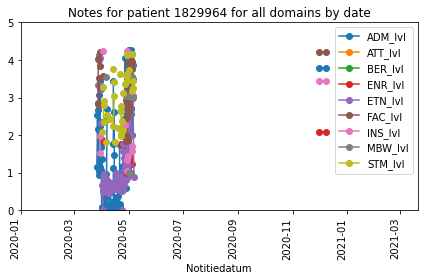

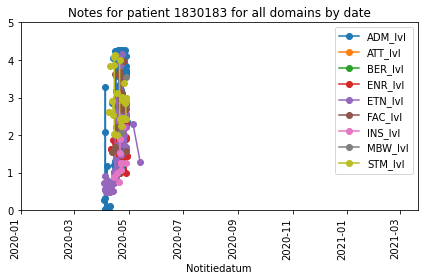

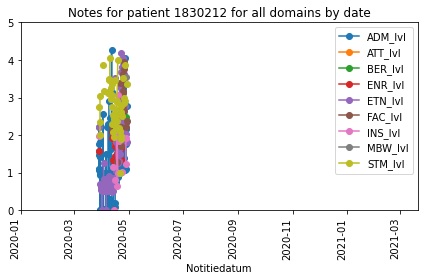

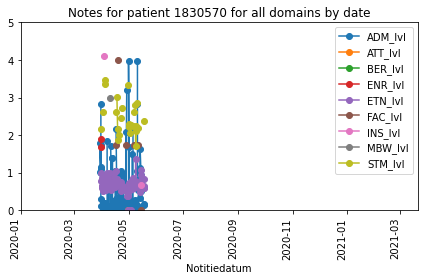

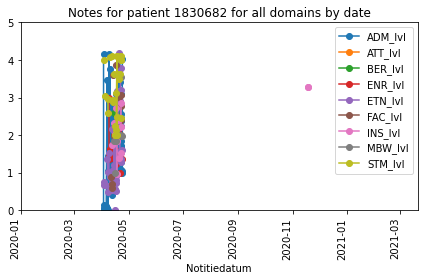

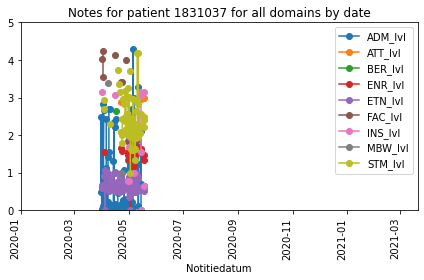

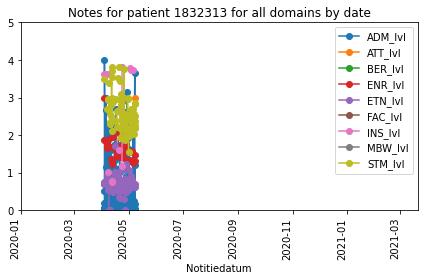

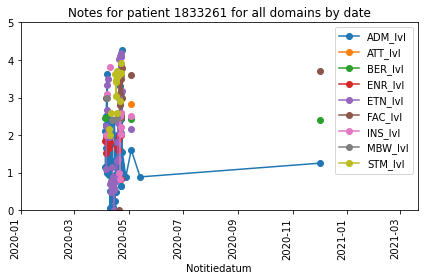

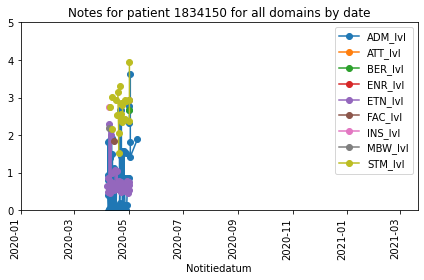

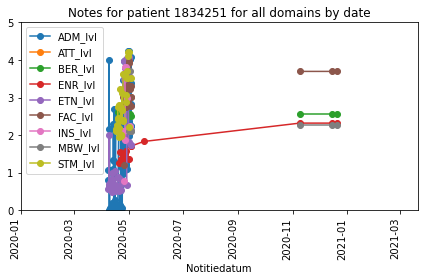

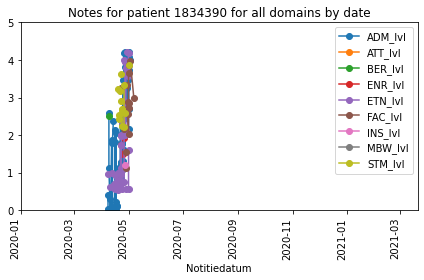

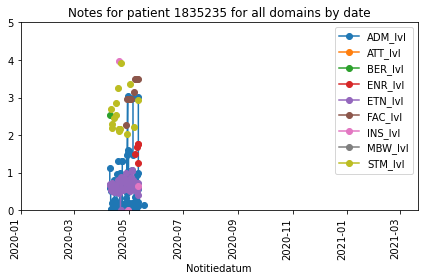

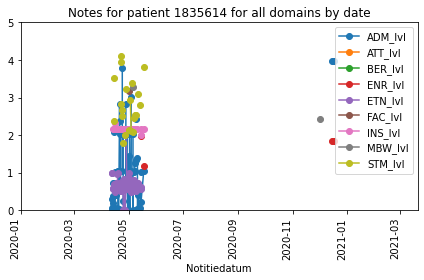

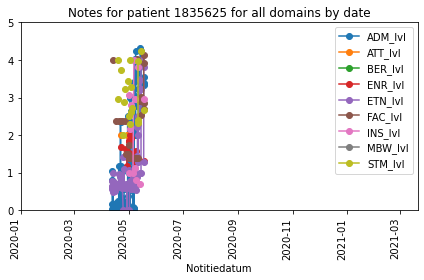

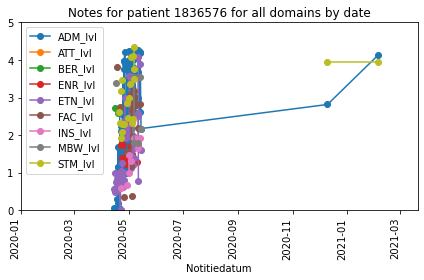

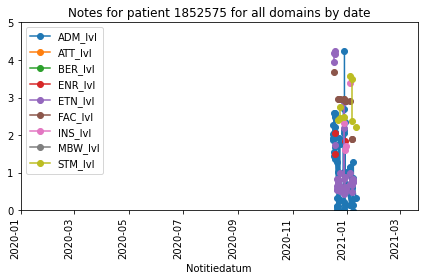

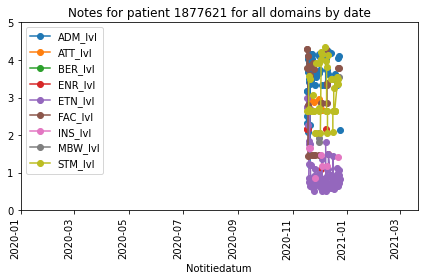

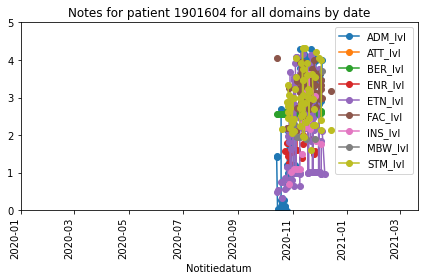

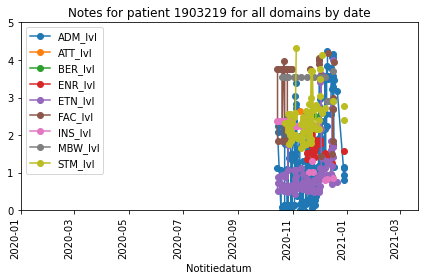

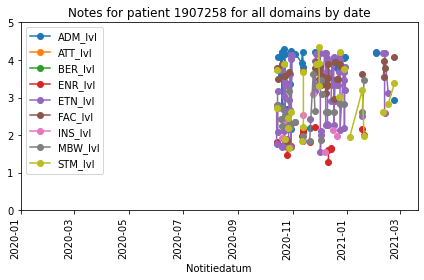

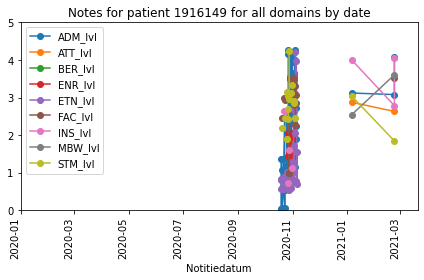

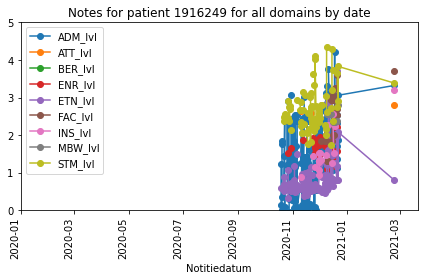

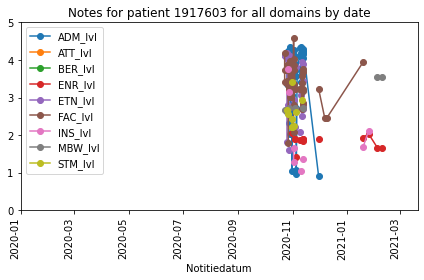

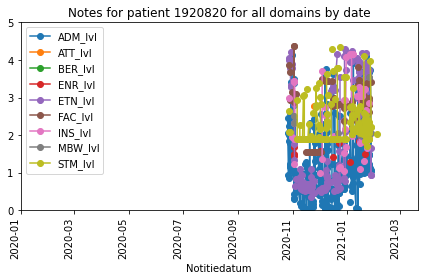

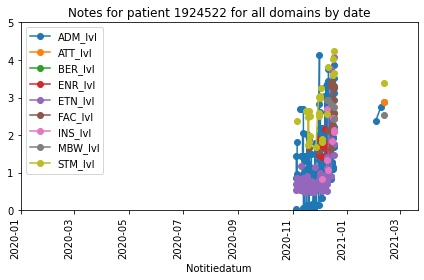

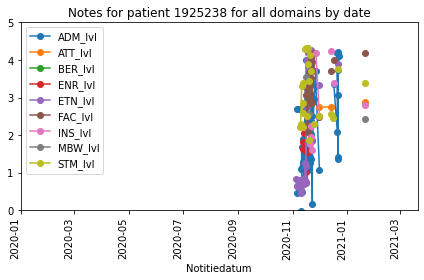

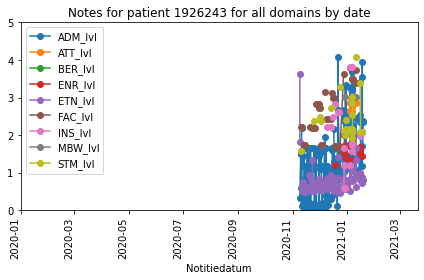

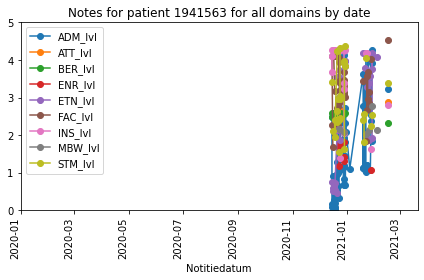

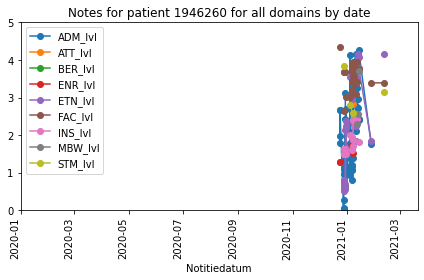

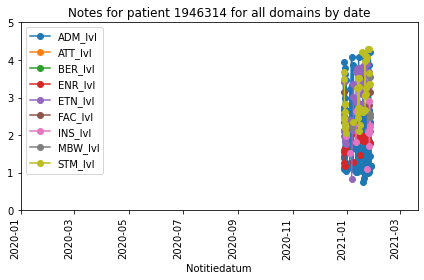

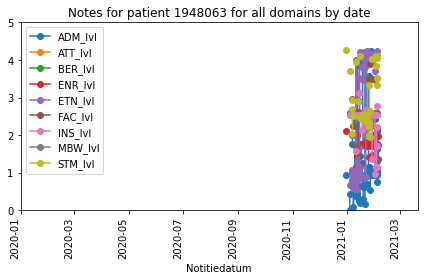

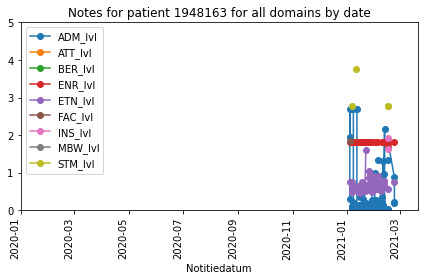

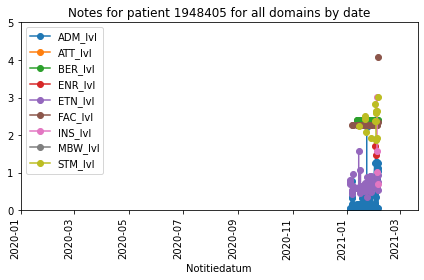

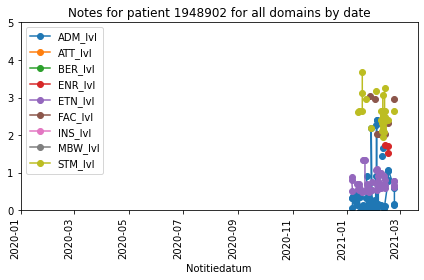

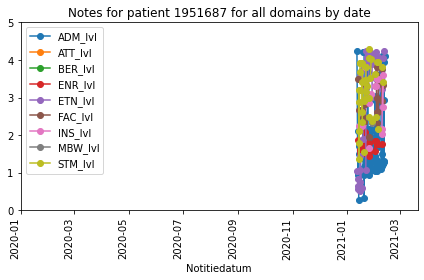

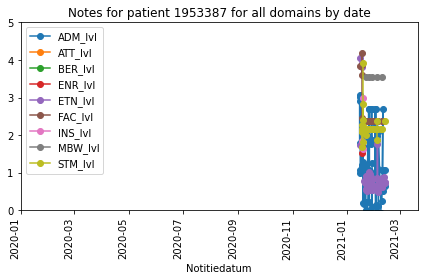

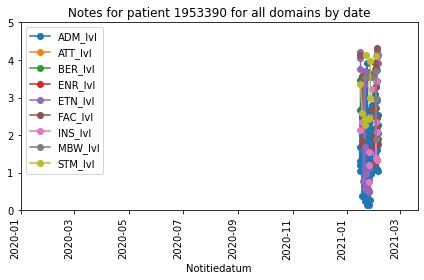

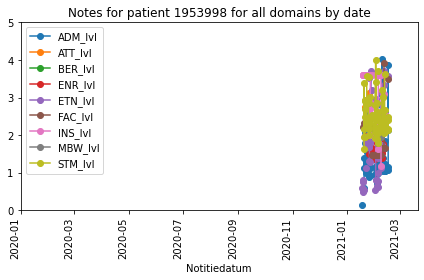

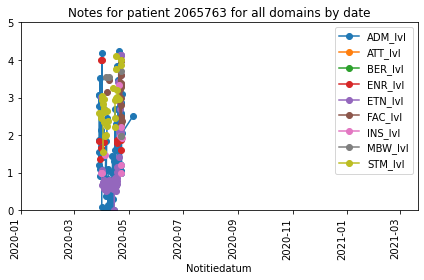

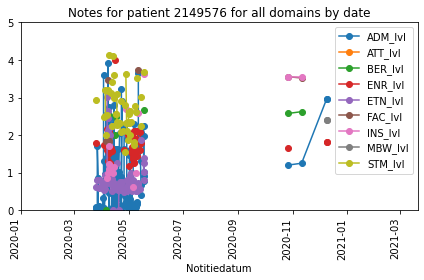

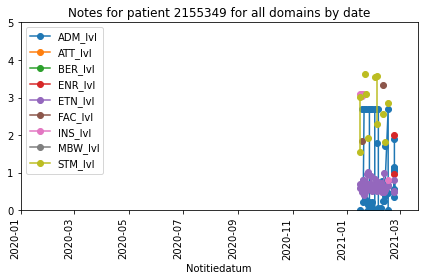

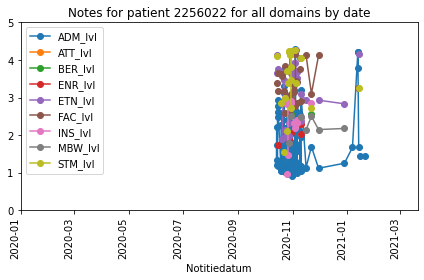

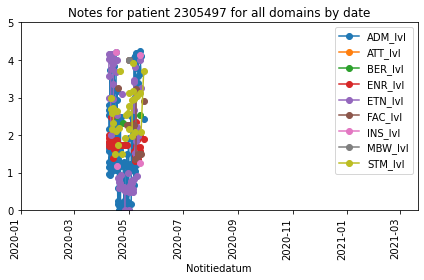

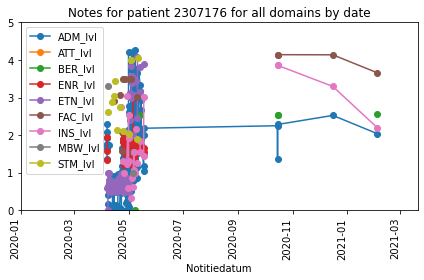

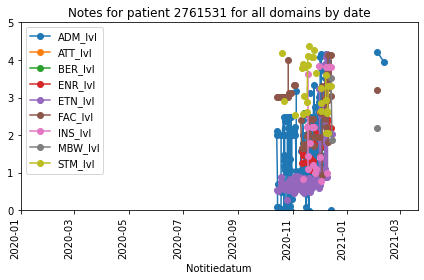

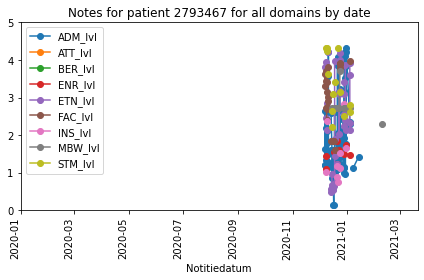

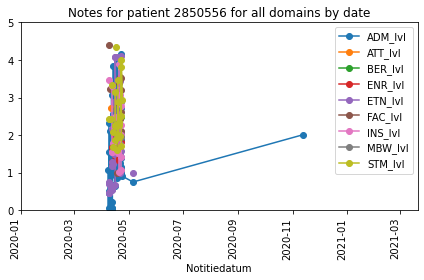

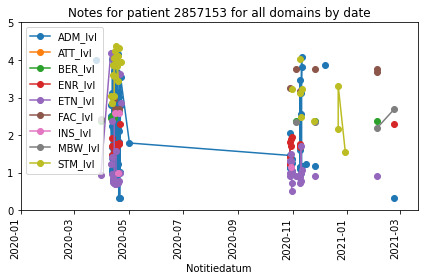

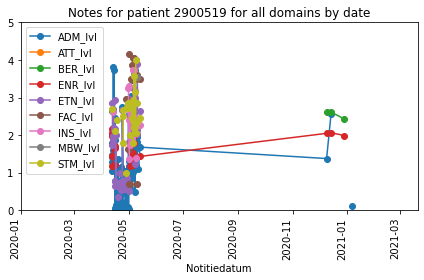

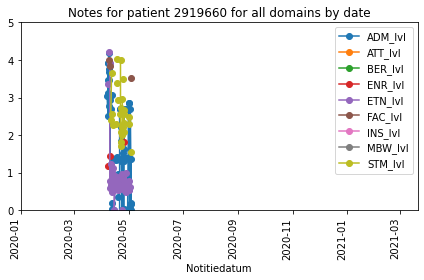

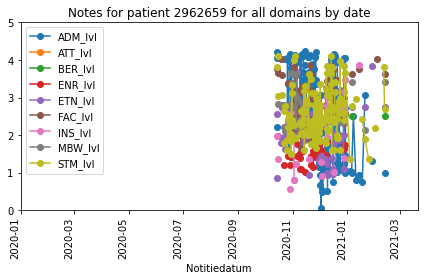

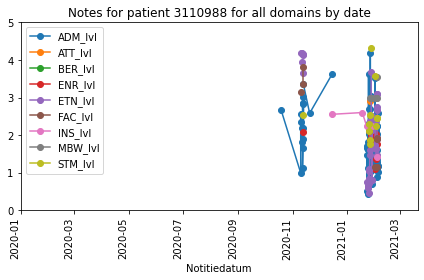

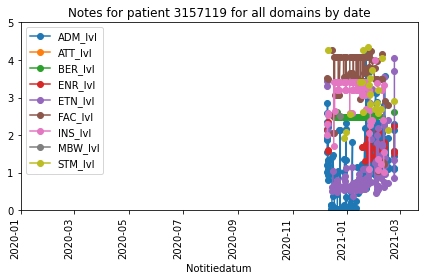

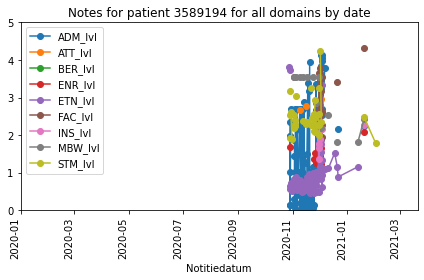

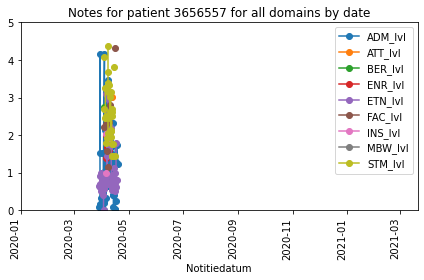

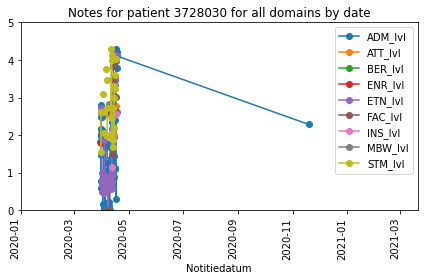

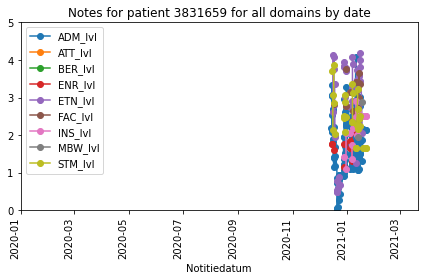

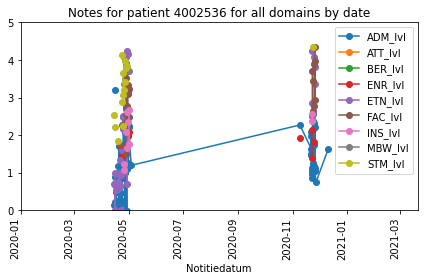

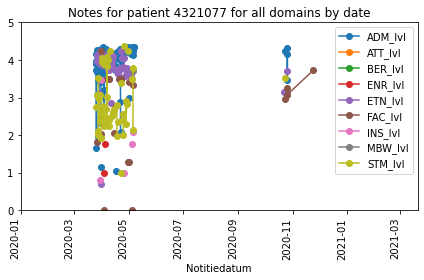

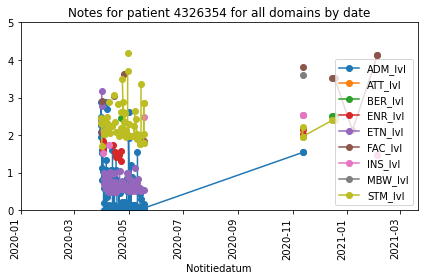

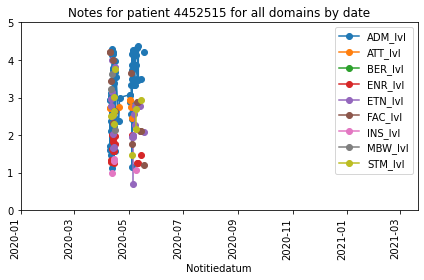

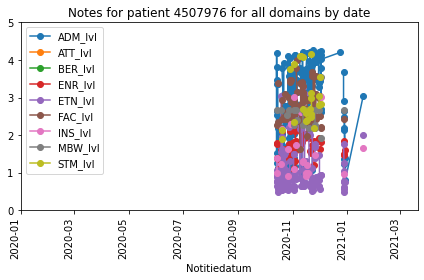

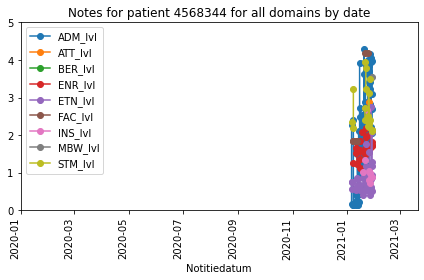

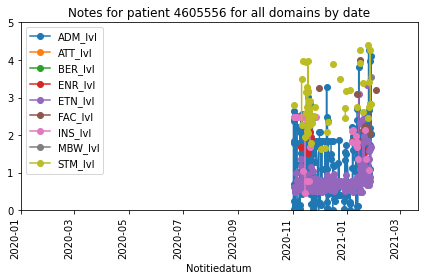

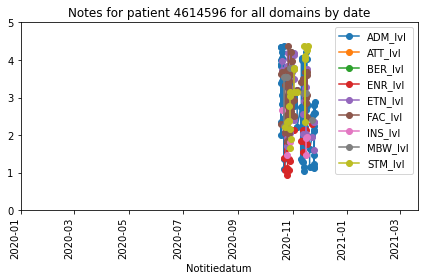

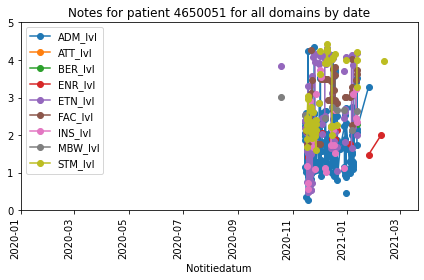

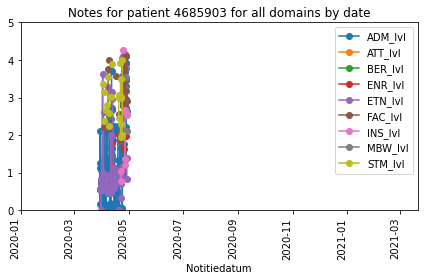

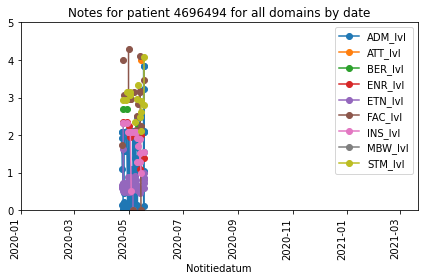

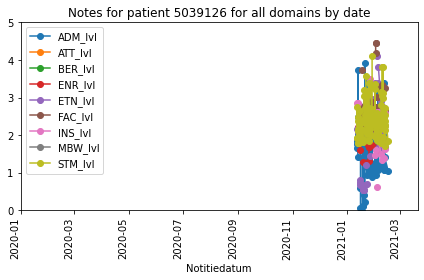

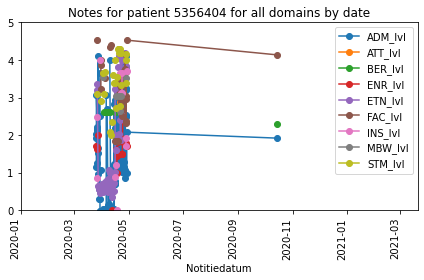

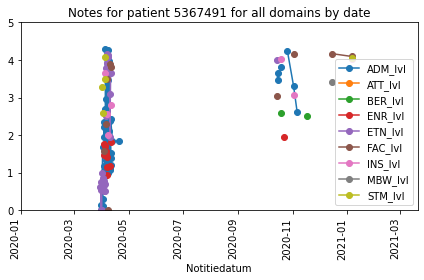

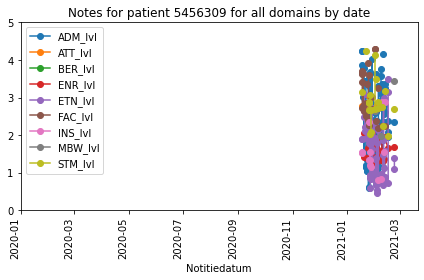

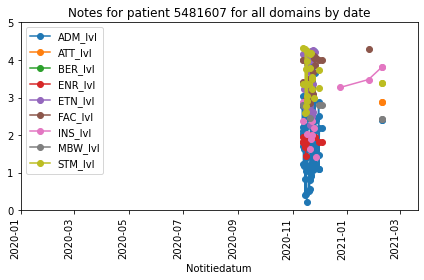

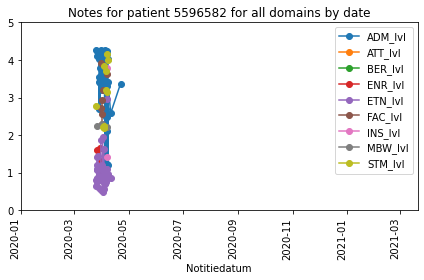

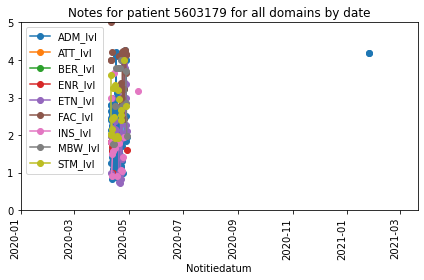

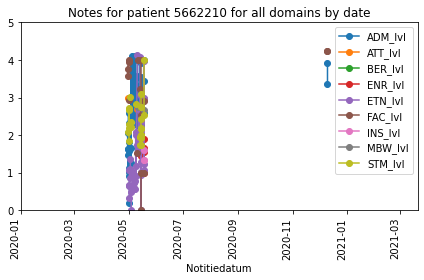

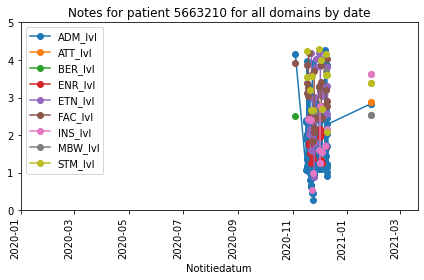

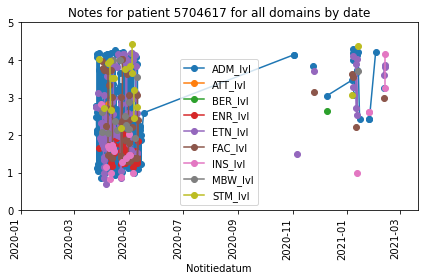

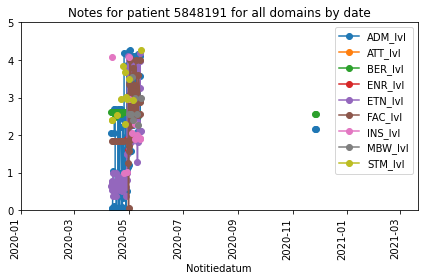

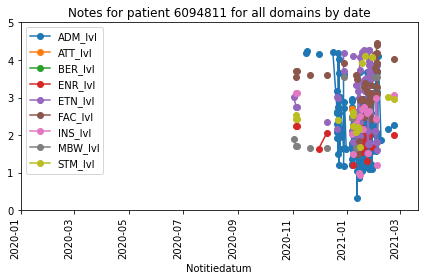

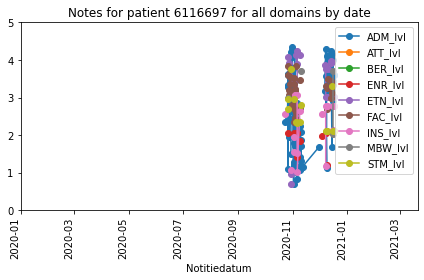

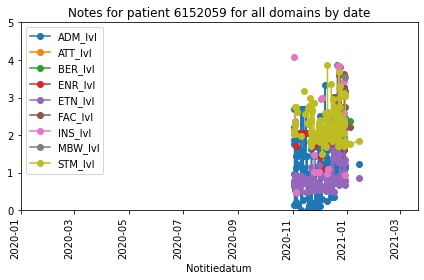

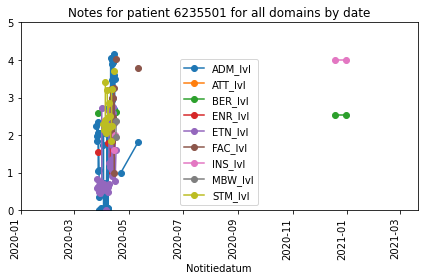

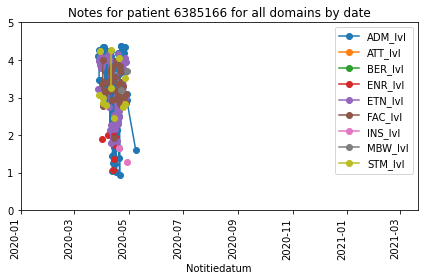

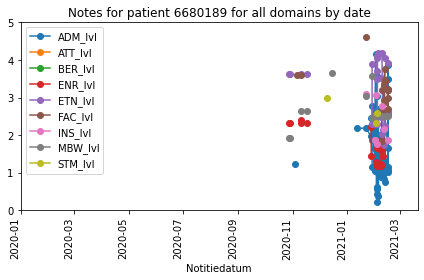

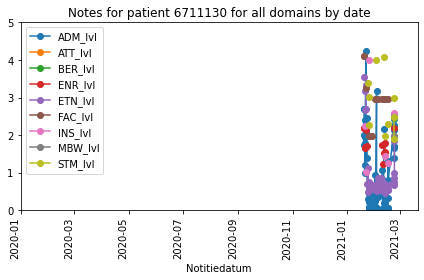

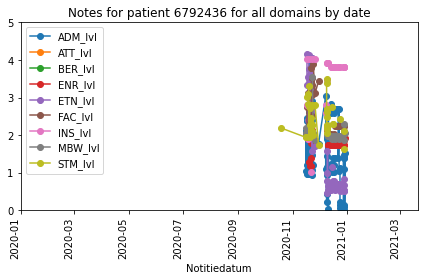

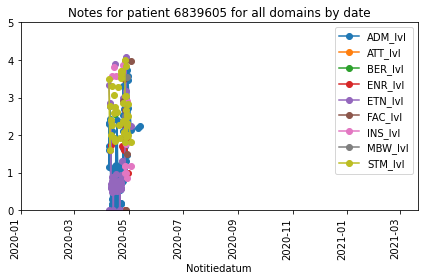

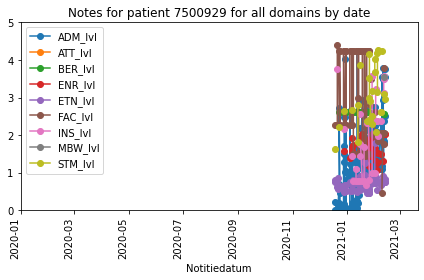

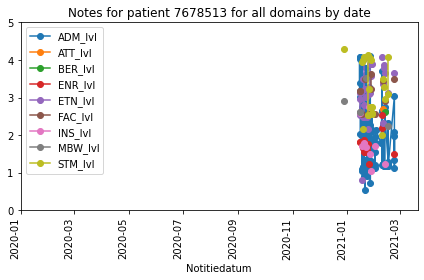

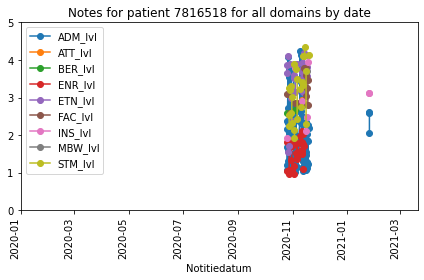

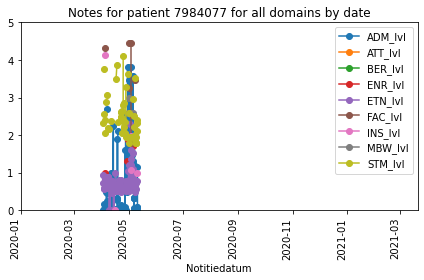

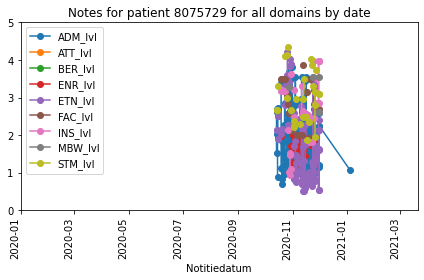

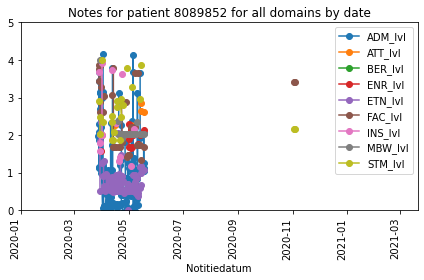

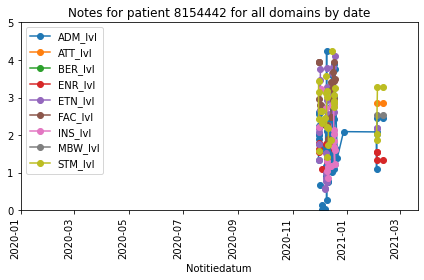

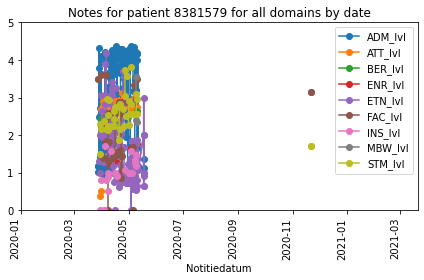

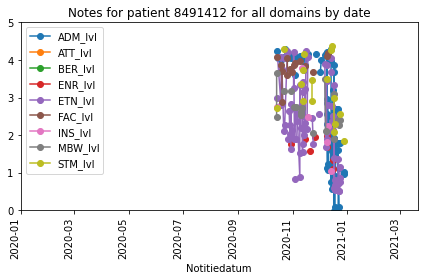

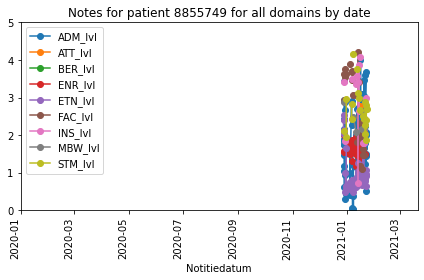

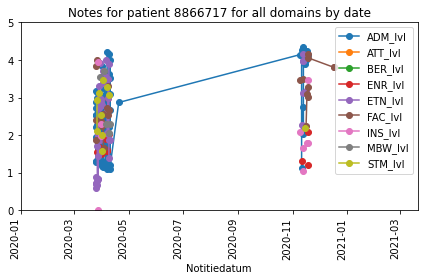

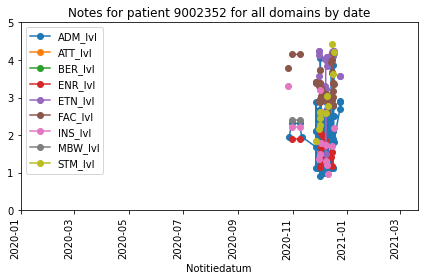

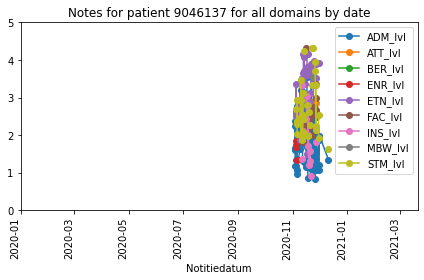

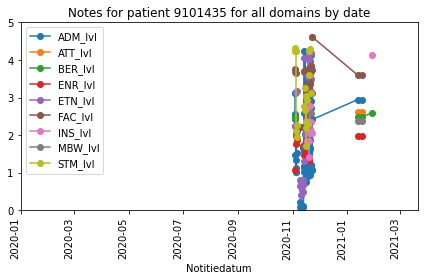

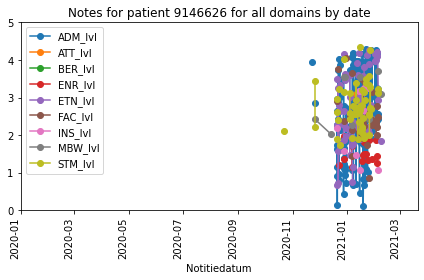

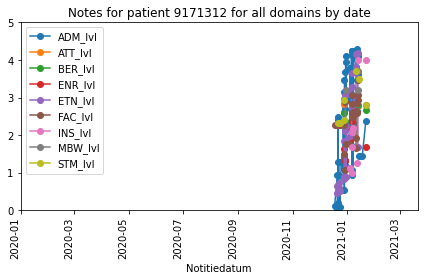

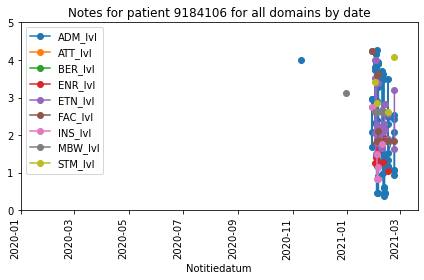

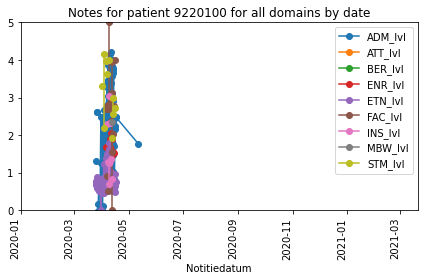

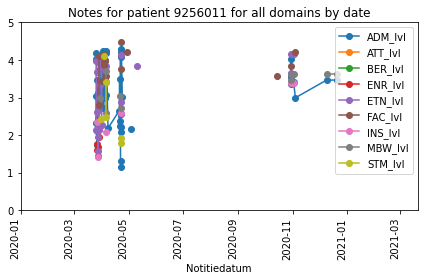

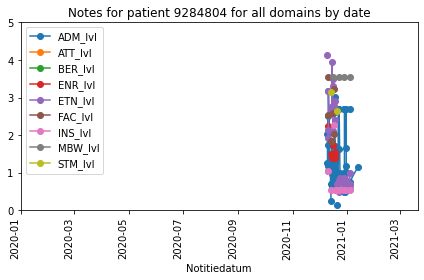

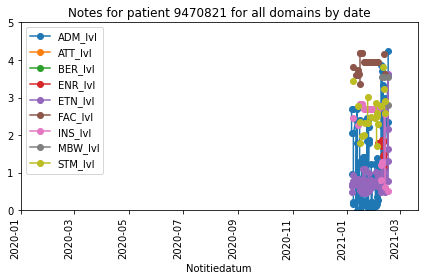

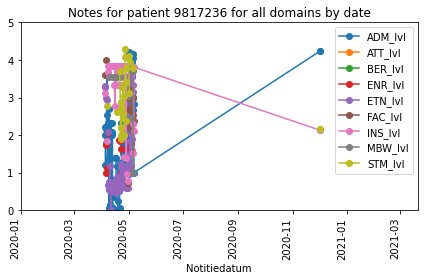

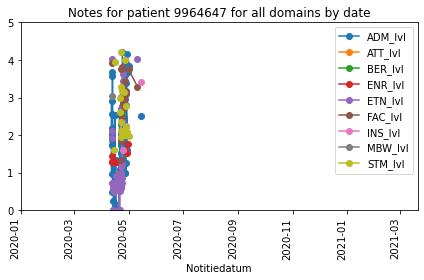

In [10]:
#plotting from people with at least 50 notes in one domain >> total of 149 ptients: 
#for 50 points per one domain at least per person we have 149 IDs
#obs: this plots disregards synthetic vs human annotated data
for i in cross_id_dom50.MDN.unique():
    data =  df_fildate[ df_fildate.MDN == i].sort_values(by='Notitiedatum', ascending=True)
    data['Notitiedatum'] = pd.to_datetime(data['Notitiedatum'])
    data.plot(kind='line', x='Notitiedatum', y=columns, marker='o', rot=90)
    #if we want to see with more detail comment xlim
    plt.xlim([datetime.date(2020, 1, 1), datetime.date(2021, 3, 21)]) 
    plt.ylim(0, 5)
    plt.title(f"Notes for patient {i} for all domains by date")
    plt.tight_layout()
    plt.show()

In [11]:
#should I filter for most important type of note? what would that be?
#pd.crosstab(df_fil100['Notitiedatum'], df_fil100['MDN']).plot(title= 'Annotations frequency over time - over 100 notes', marker='o', legend= False)
df["Typenotitie"].value_counts()

Zorgplan/VPK rapportage                         30549
Voortgangsverslag                               25852
Brief                                            5011
Consulten                                        1805
Consulten (niet-arts)                            1455
Familiegesprek                                   1430
Telefonisch contact                              1364
SEH-triagenotities                                871
VPK verloop opname                                687
MDO-verslag                                       255
SEH arts notitie                                  157
Verrichtingen                                     150
Anesthesie pre-op. evaluatie                       85
Ontslagsamenvattingen                              60
Research notitie                                   44
Notitie voor evaluatie & plan                      36
Begeleidingsadviezen en afspraken                  34
OBS Beleid                                         33
Ontslaginstr. - activiteit  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f83ebba1d30>,
      dtype=object)

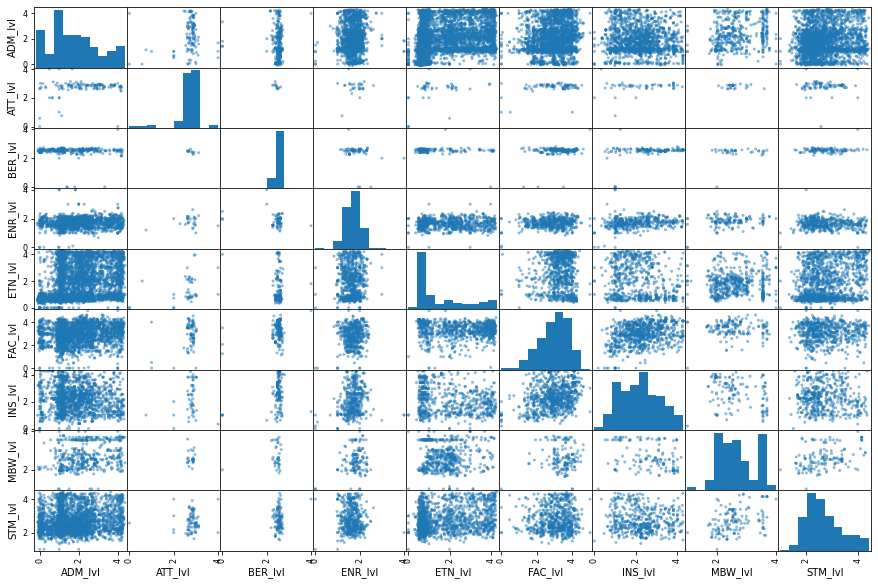

In [12]:
#how each domain relates to each other
cols = ['ADM_lvl', 'ATT_lvl', 'BER_lvl', 'ENR_lvl', 'ETN_lvl', 'FAC_lvl', 'INS_lvl', 'MBW_lvl', 'STM_lvl']     
#relevantcols = df_fildate.columns
pd.plotting.scatter_matrix(df_fildate[cols], figsize=(15,10))

In [13]:
df_fildate.to_csv('/Users/brunaguedes/Documents/GitHub/a-proof-time-series/processed/filtered_data.csv')
cross_id_dom50.to_csv('/Users/brunaguedes/Documents/GitHub/a-proof-time-series/processed/cross_id_dom.csv')